# Исследование продаж компьютерных игр
<br>


**Описание проекта**<br>
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

**Цель исследования**<br>
Выявить закономерности, определяющие успешность игры. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.<br>

**Ход исследования**<br>
1. Откроем файл с данными /datasets/games.csv и изучим общую информацию,
2. Проведем предобработку данных, подготовим их к анализу (поработаем с типами данных, пропусками, добавим при необходимости новые столбцы),
3. Проведем исследовательский анализ данных (узнаем, сколько игр было продано по годам за исследуемый период, какой период считать актуальным, какие платформы и жанры наиболее популярны и как на это влияют отзывы критиков и игроков),
4. Составим условный портрет пользователя каждого исследуемых регионов продаж - США, Европы, Японии (определим топ-5 платформ и жанров, а также проанализируем данные по возрастному рейтингу ESRB в каждом регионе).
5. Проверим гипотезы: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; Средние пользовательские рейтинги жанров Action и Sports разные.
6. Суммируем полученные результаты исследования в общем выводе.

### Откроем файл с данными и изучим общую информацию.

In [75]:
# Импортируем нужные библиотеки для чтения файла, построения графиков и проведения расчетов:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [76]:
# Сразу ограничим показ данных формата float до 2х символов после точки:
pd.options.display.float_format = '{:,.2f}'.format

df = pd.read_csv('/datasets/games.csv')

Познакомимся с основной информацей о датасете:

In [77]:
# Общая информация по всем столбцам:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [78]:
# Описание числовых характеристик:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,"16,446.00","16,715.00","16,715.00","16,715.00","16,715.00","8,137.00"
mean,"2,006.48",0.26,0.15,0.08,0.05,68.97
std,5.88,0.81,0.50,0.31,0.19,13.94
min,"1,980.00",0.00,0.00,0.00,0.00,13.00
25%,"2,003.00",0.00,0.00,0.00,0.00,60.00
50%,"2,007.00",0.08,0.02,0.00,0.01,71.00
75%,"2,010.00",0.24,0.11,0.04,0.03,79.00
max,"2,016.00",41.36,28.96,10.22,10.57,98.00


In [79]:
# Первые пять строк таблицы:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,"2,006.00",Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,"1,985.00",Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,"2,008.00",Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,"2,009.00",Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,"1,996.00",Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Вывод после знакомства с данными**<br>
Что нужно будет сделать далее в предобработке:

 - Обновить наименования столбцов, переписать их в нижнем регистре,
 - Проанализировать пропуски (столбцы Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating) и, если это возможно,- заполнить их данными (запомним, что в столбцах 'Name' и 'Genre' по 2 пропуска, может они в одних и тех же строках?),
 - Заменить формат столбца Year_of_Release с float на int (год - целое число, отображение с точкой нам не нужно), User_Score c object на float (оценка - дробное значение, а не текст),
 - Поменять тип данных с float64 на float32 для экономии памяти.

### Предобработка данных

In [80]:
# Переведем названия столбцов в нижний регистр
df.columns = df.columns.str.lower()

# Для дальнейшего удобства сразу создадим словарь с описанием столбцов и функцию с вызовом их основных характеристик:
# словарь с описанием столбцов
dict_df ={
     'name': 'название игры',
     'platform':'платформа',
     'year_of_release':'год выпуска',
     'genre': 'жанр игры',
     'na_sales': 'продажи в Северной Америке (миллионы проданных копий)',
     'eu_sales':'продажи в Европе (миллионы проданных копий)',
     'jp_sales': 'продажи в Японии (миллионы проданных копий)',
     'other_sales': 'продажи в других странах (миллионы проданных копий)',
     'critic_score': 'оценка критиков (максимум 100)', 
     'user_score': 'оценка пользователей (максимум 10)',
     'rating': 'рейтинг от организации ESRB (англ. Entertainment Software Rating Board)'
}

# словарь со значениями 
dict_name = pd.Series(dict_df)

По опыту прошлых проектов знаем, что удобнее будет сразу задать функцию:

In [81]:
# Функция просмотра данных столбца: уникальные значения, тип данных, кол-во пропусков
def column_info(column):
    print(column, '-', dict_name[column])
    print('тип данных', df[column].dtypes)
    print('количество пропусков',df[column].isna().sum())
    if df[column].dtypes != 'object':
        print('минимальное значение:', df[column].min(), 'максимальное значение:', df[column].max() )
    print()
    print('уникальные значения:', '\n', df[column].value_counts(dropna=False))

**Столбец name**

In [82]:
column_info('name')

name - название игры
тип данных object
количество пропусков 2

уникальные значения: 
 Need for Speed: Most Wanted                       12
Ratatouille                                        9
Madden NFL 07                                      9
LEGO Marvel Super Heroes                           9
FIFA 14                                            9
                                                  ..
Onechanbara: Bikini Samurai Squad                  1
Jikkyou Powerful Pro Yakyuu Wii Ketteiban          1
Kouchuu Ouja Mushi King: Super Collection          1
Joker no Kuni no Alice: Wonderful Wonder World     1
Moto Racer World Tour                              1
Name: name, Length: 11560, dtype: int64


**Столбец genre**

In [83]:
column_info('genre')

genre - жанр игры
тип данных object
количество пропусков 2

уникальные значения: 
 Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
NaN                2
Name: genre, dtype: int64


Помним, что в столбцах name и genre одинаковое количество пропусков. Это одни и те же строки?

In [84]:
df.loc[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,"1,993.00",NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,"1,993.00",NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Так и есть: для этих строк мы не видим ни названия игры, ни хотя бы её жанра.<br>
Продажи этой неизвестной игры низкие, а платформа давно устарела: можем смело удалить строки, точность анализа без них не пострадает.

In [85]:
df.drop(index = [659, 14244], inplace = True)
df.loc[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


**Столбец platform**

In [86]:
column_info('platform')

platform - платформа
тип данных object
количество пропусков 0

уникальные значения: 
 PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
GB        98
NES       98
DC        52
GEN       27
NG        12
WS         6
SCD        6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64


Пропусков нет, на первый взгляд всё в порядке.

**Столбец year_of_release**

In [87]:
column_info('year_of_release')

year_of_release - год выпуска
тип данных float64
количество пропусков 269
минимальное значение: 1980.0 максимальное значение: 2016.0

уникальные значения: 
 2,008.00    1427
2,009.00    1426
2,010.00    1255
2,007.00    1197
2,011.00    1136
2,006.00    1006
2,005.00     939
2,002.00     829
2,003.00     775
2,004.00     762
2,012.00     653
2,015.00     606
2,014.00     581
2,013.00     544
2,016.00     502
2,001.00     482
1,998.00     379
2,000.00     350
1,999.00     338
1,997.00     289
NaN          269
1,996.00     263
1,995.00     219
1,994.00     121
1,993.00      60
1,981.00      46
1,992.00      43
1,991.00      41
1,982.00      36
1,986.00      21
1,983.00      17
1,989.00      17
1,990.00      16
1,987.00      16
1,988.00      15
1,984.00      14
1,985.00      14
1,980.00       9
Name: year_of_release, dtype: int64


В столбце 269 пропусков, или 1.61% от всех значений. 

Можно было бы попробовать заполнить их медианой по годам игр с тем же названием, но на другой платформе.
Но способ всё-таки авантюрный и неточный: годы релиза на разных платформах могут заметно отличаться. 

Более точных закономерностей нет, поэтому удалим эти 269 строк.

Перед удалением строк и сразу после применим метод .shape к датафрейму. Так мы проверим, сколько строк было удалено.

In [88]:
df.shape

(16713, 11)

In [89]:
df.dropna(subset=['year_of_release'], inplace = True)
df.query('year_of_release.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


In [90]:
df.shape

(16444, 11)

**Столбцы со статистикой продаж: na_sales, eu_sales, jp_sales, other_sales**

In [91]:
column_info('na_sales')

na_sales - продажи в Северной Америке (миллионы проданных копий)
тип данных float64
количество пропусков 0
минимальное значение: 0.0 максимальное значение: 41.36

уникальные значения: 
 0.00     4449
0.02      562
0.03      554
0.04      543
0.05      536
         ... 
14.44       1
13.96       1
2.35        1
2.96        1
4.40        1
Name: na_sales, Length: 401, dtype: int64


In [92]:
column_info('eu_sales')

eu_sales - продажи в Европе (миллионы проданных копий)
тип данных float64
количество пропусков 0
минимальное значение: 0.0 максимальное значение: 28.96

уникальные значения: 
 0.00    5766
0.01    1467
0.02    1290
0.03     911
0.04     702
        ... 
9.14       1
1.92       1
3.86       1
2.59       1
3.87       1
Name: eu_sales, Length: 307, dtype: int64


In [93]:
column_info('jp_sales')

jp_sales - продажи в Японии (миллионы проданных копий)
тип данных float64
количество пропусков 0
минимальное значение: 0.0 максимальное значение: 10.22

уникальные значения: 
 0.00    10300
0.02      733
0.01      697
0.03      540
0.04      391
        ...  
3.84        1
1.17        1
3.03        1
2.66        1
1.71        1
Name: jp_sales, Length: 244, dtype: int64


In [94]:
column_info('other_sales')

other_sales - продажи в других странах (миллионы проданных копий)
тип данных float64
количество пропусков 0
минимальное значение: 0.0 максимальное значение: 10.57

уникальные значения: 
 0.00    6492
0.01    3398
0.02    1596
0.03     910
0.04     641
        ... 
0.72       1
2.11       1
0.96       1
1.48       1
3.96       1
Name: other_sales, Length: 155, dtype: int64


Пропусков в столбцах со статистикой продаж нет, критичных значений тоже, оставим эти столбцы без изменений.

**Столбец critic_score**

In [95]:
column_info('critic_score')

critic_score - оценка критиков (максимум 100)
тип данных float64
количество пропусков 8461
минимальное значение: 13.0 максимальное значение: 98.0

уникальные значения: 
 NaN      8461
70.00     252
71.00     248
75.00     240
80.00     235
         ... 
20.00       3
29.00       3
21.00       1
17.00       1
13.00       1
Name: critic_score, Length: 82, dtype: int64


Здесь наибольшее количество пропусков датафрейма: 51.32% <br>

Можно попробовать обработать и заполнить медианными значениями в зависимости от года выпуска, жанра и платформы.<br>
Но есть риск, что результат будет неточным и исказит анализ, поэтому оставим как есть. 

**Столбец user_score**

In [96]:
column_info('user_score')

user_score - оценка пользователей (максимум 10)
тип данных object
количество пропусков 6605

уникальные значения: 
 NaN    6605
tbd    2376
7.8     322
8       285
8.2     276
       ... 
1.1       2
0.3       2
2.3       2
0         1
9.7       1
Name: user_score, Length: 97, dtype: int64


Пропущено 40% значений. Также среди уникальных значений встречается аббревиатура tbd (видимо, от английского 'to be determined' - 'предстоит определить') для игр, по которым еще не рассчитан рейтинг пользователей.<br>

Как и пропуски, значение tbd говорит об отсутствии оценки пользователя, поэтому заменим ее на пропуск (nan).<br>
Сами пропуски оставим незаполненными, чтобы впоследствии не исказить анализ.

In [97]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = float('nan')

**И, наконец, столбец rating**

In [98]:
column_info('rating')

rating - рейтинг от организации ESRB (англ. Entertainment Software Rating Board)
тип данных object
количество пропусков 6676

уникальные значения: 
 NaN     6676
E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64


Заменим пропуски на более понятное 'no rating'

In [99]:
df['rating'] = df['rating'].fillna('no rating')

# Проверим результат
column_info('rating')

rating - рейтинг от организации ESRB (англ. Entertainment Software Rating Board)
тип данных object
количество пропусков 0

уникальные значения: 
 no rating    6676
E            3921
T            2905
M            1536
E10+         1393
EC              8
K-A             3
RP              1
AO              1
Name: rating, dtype: int64


**Теперь займемся корректировкой типов данных**

In [100]:
# Посмотрим, как было до корректировок:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   object 
 10  rating           16444 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [101]:
# Переведем значения 'year_of_release' в целочисленный тип int.
df['year_of_release'] = df['year_of_release'].astype('int32')

# Заменим тип данных user_score на float:
df['user_score'] = df['user_score'].astype('float32')

# Остальные столбцы тоже можно оптимизировать.
# Заменим float64 на float32:
df['na_sales'] = df['na_sales'].astype('float32')
df['eu_sales'] = df['eu_sales'].astype('float32')
df['jp_sales'] = df['jp_sales'].astype('float32')
df['other_sales'] = df['other_sales'].astype('float32')
df['critic_score'] = df['critic_score'].astype('float32')

In [102]:
# Проверим результат
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float32
 5   eu_sales         16444 non-null  float32
 6   jp_sales         16444 non-null  float32
 7   other_sales      16444 non-null  float32
 8   critic_score     7983 non-null   float32
 9   user_score       7463 non-null   float32
 10  rating           16444 non-null  object 
dtypes: float32(6), int32(1), object(4)
memory usage: 1.1+ MB


После изменений объем выделяемой памяти снизился с 1.5+ до 1.1+ MB. Небольшая, но всё-таки экономия.

In [28]:
# Проверим наличие явных дубликатов
df.duplicated().sum()

0

Отлично, их нет 

**Почему мы всё это сделали:**

Типы данных мы меняли, так как они бывают разные, это не всегда подходит для анализа.

Пропуски тоже мешают анализу. Общие причины, которые могут привести к пропускам в данных:

Причина 1 - если пользователь не заполнил форму до конца, не дал сведений о себе (контактный номер, фамилию и т.п.),<br>
Причина 2 - если произошла техническая ошибка в работе системы сбора информации (например, при выгрузке данных из разных систем некорректный формат приводит к невыполнению кода).<br>
Причина 3 - если пропуск был оставлен умышленно в расчете на автозаполнение спецсимволами.

**Суммарные продажи во всех регионах**

In [103]:
# Создадим новый столбец на основе других столбцов:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

# Заодно сразу переместим его из конца списка в более подходящее место, после other_sales:
df = df[[
 'name',  
 'platform',
 'year_of_release',
 'genre',
 'na_sales',
 'eu_sales',
 'jp_sales',
 'other_sales',
 'total_sales',
 'critic_score',
 'user_score',
 'rating'
]]

# Посмотрим на полученные значения:
df['total_sales'].head()

0   82.54
1   40.24
2   35.52
3   32.77
4   31.38
Name: total_sales, dtype: float32

In [104]:
# Проверим порядок столбцов:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float32
 5   eu_sales         16444 non-null  float32
 6   jp_sales         16444 non-null  float32
 7   other_sales      16444 non-null  float32
 8   total_sales      16444 non-null  float32
 9   critic_score     7983 non-null   float32
 10  user_score       7463 non-null   float32
 11  rating           16444 non-null  object 
dtypes: float32(7), int32(1), object(4)
memory usage: 1.1+ MB


**Вывод по предобработке**<br>

В результате предобработки данных:
- Наименования столбцов переписаны в нижнем регистре,
- Удалены строки с пропусками данных в столбцах name и rating (2 строки), year_of_release (269 строк),
- Значения 'tbd' в столбце user_score изменено на значение пропуска (nan),
- Пропуски значений столбца rating заменены на значение 'no rating',
- Пропуски значений столбца user_score и critic_score оставлены без изменений в связи с невозможностью корректной замены,
- Создан столбец total_sales, суммирующий продажи во всех регионах.

Данные готовы к анализу.

### Исследовательский анализ данных

**Анализ количества выпущенных игр за разные годы.**<br>
Сгруппируем количество игр по годам релиза:

In [105]:
games_by_year = df.groupby('year_of_release')[['name']].agg('count').reset_index()

games_by_year.columns = ['year_of_release', 'count']

games_by_year

,year_of_release,count
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


Видно, как в начале 2000х продажи стали расти, но всё-таки не наглядно. Построим график.

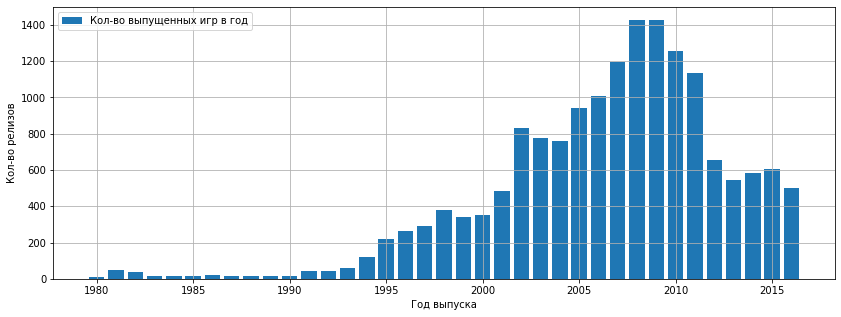

In [106]:
plt.figure(figsize=(14, 5))
plt.bar(games_by_year['year_of_release'], games_by_year['count'], label='Кол-во выпущенных игр в год')
plt.xlabel('Год выпуска')
plt.ylabel('Кол-во релизов')
plt.grid()
plt.legend()
plt.show();

Начиная с 1991 года виден устойчивый рост (с небольшими локальными спадами в 1999 и 2003) до пиковых значений в 2008-2009 году, затем снижение (с 2011 по 2012 очень резкое). В итоге 2016 год вернулся на уровень, сопоставимый с 2001.

Данные до 1991 года на фоне следующих лет выглядят слишком малыми, на уровне погрешности.<br>
Их можно смело исключить из анализа, чтобы сконцентрироваться на более релевантной статистике.

In [107]:
# Исключим данные до 1991 года
df = df.query('year_of_release > 1990')

# Убедимся, что 1991 год - наименьшее значение среди оставленных годов.
df['year_of_release'].unique().min()

1991

**Анализ игр по платформам.**<br>
Продажи по самым популярным платформам (топ-5).

Сгруппируем игры по платформам:

In [108]:
platform_year = df.groupby('platform')['total_sales'].agg(['count', 'sum']
                                    ).sort_values(by='sum', ascending = False).reset_index()
platform_year.columns = ['platform', 'game_by_platform_count', 'game_by_platform_sales' ]

platform_year

,platform,game_by_platform_count,game_by_platform_sales
0,PS2,2127,"1,233.56"
1,X360,1232,961.24
2,PS3,1306,931.34
3,Wii,1286,891.18
4,DS,2120,802.76
5,PS,1190,727.58
6,PS4,392,314.14
7,GBA,811,312.88
8,PSP,1193,289.53
9,3DS,512,257.81


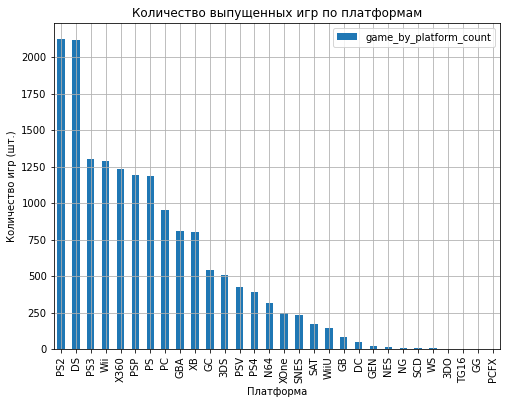

In [109]:
# Наглядный график выпуска игр:
platform_year.sort_values(by =  'game_by_platform_count', ascending= False).plot.bar(
                    x = 'platform', y = 'game_by_platform_count', grid=True, 
                    title='Количество выпущенных игр по платформам',
                    figsize=(8,6)).set(xlabel='Платформа', ylabel='Количество игр (шт.)');

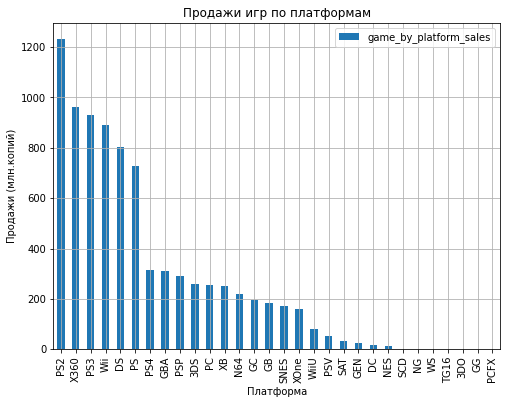

In [110]:
# График продаж:
platform_year.plot.bar(
                    x = 'platform', y = 'game_by_platform_sales', grid=True, 
                    title='Продажи игр по платформам',
                    figsize=(8,6)).set(xlabel='Платформа', ylabel='Продажи (млн.копий)');

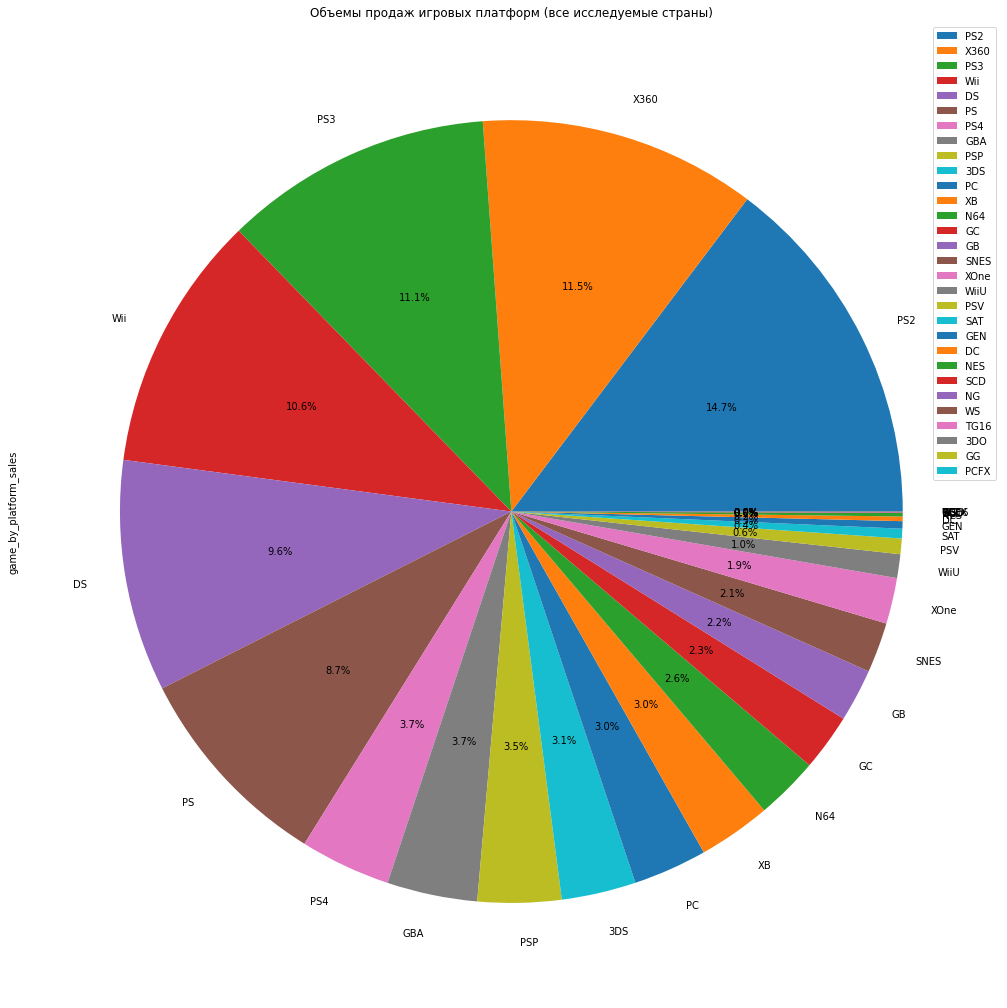

In [111]:
# Посмотрим процентное соотношение:
platform_year.plot(kind = 'pie', y ='game_by_platform_sales', autopct='%1.1f%%', figsize= (18,18),
                         title = 'Объемы продаж игровых платформ (все исследуемые страны)', labels = platform_year['platform']
                         );

Лидеры продаж:  Sony PlayStation (PS1, PS2, PS3), Nintendo DS, Wii, Xbox360 от Microsoft. <br>

Итак, наиболее успешные платформы принадлежат трем компаниями: 
- 34,5% продаж у Sony, 
- 20.2% - Nintendo, 
- 11.5% - Microsoft. <br>

Соответственно, эти компании лидируют по количеству выпущенных игр.

**Платформы с наибольшими продажами**

In [112]:
# Топ-5 по объемам продаж:
top_platforms = platform_year.head(5)['platform']
top_platforms

0     PS2
1    X360
2     PS3
3     Wii
4      DS
Name: platform, dtype: object

In [113]:
# Сгруппируем Топ-5 платформ по годам релиза:
top = df.query('platform in @top_platforms').pivot_table(
                       index='year_of_release', columns = 'platform', 
                       values = 'total_sales', aggfunc = 'sum')
top

platform,DS,PS2,PS3,Wii,X360
year_of_release,,,,,
2000,NaN,39.17,NaN,NaN,NaN
2001,NaN,166.43,NaN,NaN,NaN
2002,NaN,205.38,NaN,NaN,NaN
2003,NaN,184.31,NaN,NaN,NaN
2004,17.27,211.81,NaN,NaN,NaN
2005,130.14,160.66,NaN,NaN,8.25
2006,119.81,103.42,20.96,137.15,51.62
2007,146.94,75.99,73.19,152.77,95.41
2008,145.31,53.90,118.52,171.32,135.26


(2000.0, 2016.0)

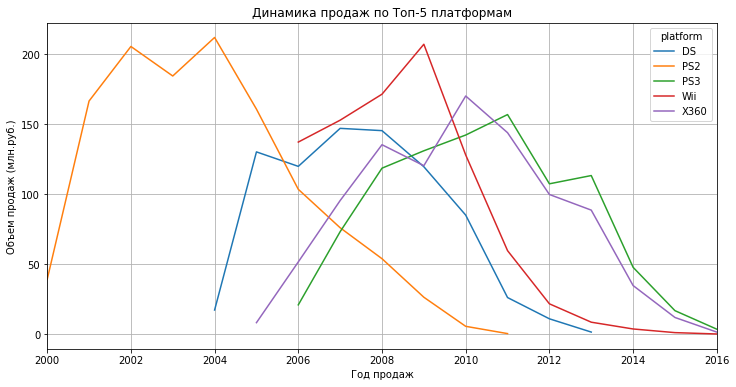

In [114]:
top.plot(grid=True, figsize=(12, 6), title = 'Динамика продаж по Топ-5 платформам').set(
                                     xlabel = 'Год продаж', ylabel = 'Объем продаж (млн.руб.)');
plt.xlim(2000, 2016)

Видим, как на закате PS2 появляется PS3 в попытке вернуть прежние объёмы.<br>
Параллельно появляется и сильный конкурент X360, идут практически одинаково.<br>
Nintendo Wii поначалу показывал высокие продажи, но быстро сник, а карманный DS жил своей жизнью, он не прямой конкурент другим топам.

Проанализируем каждого лидера отдельно:

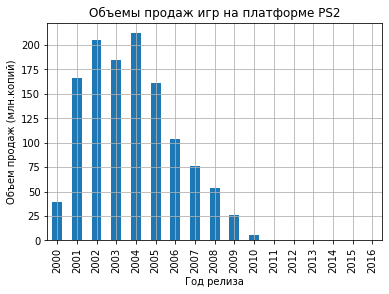

In [115]:
top['PS2'].plot.bar(
                    x = 'year_of_release', y = 'total_sales', grid=True, 
                    title='Объемы продаж игр на платформе PS2'
                    ).set(xlabel='Год релиза', ylabel='Объем продаж (млн.копий)');

Sony PS2 абсолютный лидер по количеству выпущенных игр и объемам продаж.<br>
Платформа стала популярна сразу на следующий год после релиза, а пик продаж был в 2004 году.<br>
Начиная с 2005 года  - быстрое снижение популярности.

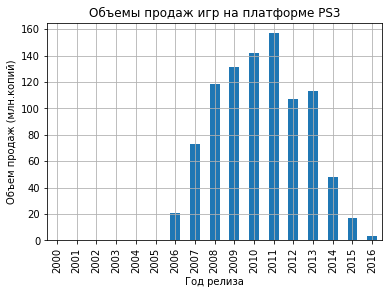

In [116]:
top['PS3'].plot.bar(
                    x = 'year_of_release', y = 'total_sales', grid=True, 
                    title='Объемы продаж игр на платформе PS3'
                    ).set(xlabel='Год релиза', ylabel='Объем продаж (млн.копий)');

Наследница PS2 - Sony PS3 в 2011 году показала максимум, но всё же хуже, чем PS2.<br>
Затем снова быстрый спад.

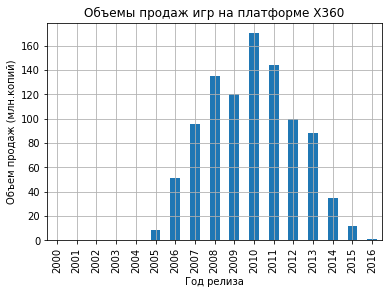

In [117]:
top['X360'].plot.bar(
                    x = 'year_of_release', y = 'total_sales', grid=True, 
                    title='Объемы продаж игр на платформе X360'
                    ).set(xlabel='Год релиза', ylabel='Объем продаж (млн.копий)');

Продажи игр главного конкурента PS3 - X360 от Microsoft - подсказывают, почему PS3 стала менее популярна, чем предшественница.<br>
C 2006 года X360 сразу включается в конкурентную борьбу и достигает пика в 2011 году.

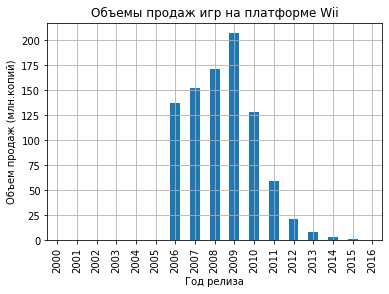

In [118]:
top['Wii'].plot.bar(
                    x = 'year_of_release', y = 'total_sales', grid=True, 
                    title='Объемы продаж игр на платформе Wii'
                    ).set(xlabel='Год релиза', ylabel='Объем продаж (млн.копий)');

Nintendo Wii, в отличие от PS X360, уже в первый год резко становится популярна, достигает пика в 2009 году, и также резко теряет популярность.

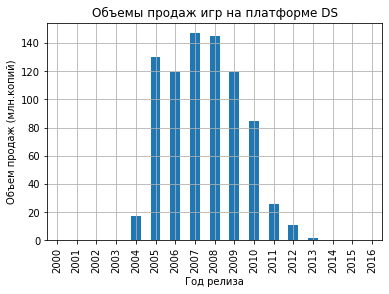

In [119]:
top['DS'].plot.bar(
                    x = 'year_of_release', y = 'total_sales', grid=True, 
                    title='Объемы продаж игр на платформе DS'
                    ).set(xlabel='Год релиза', ylabel='Объем продаж (млн.копий)');

Nintendo DS также резко популярна уже на второй год продаж, пик в 2008-2009 годах, затем спад.

Посчитаем средний срок жизни платформы исходя из данных по Топ-5:

In [120]:
#средний срок жизни платформы
sum_pl = 0
count_pl = 0
for name in top.columns:
    sum_pl += top.loc[top[name].notna(), name].count()
    count_pl += 1
print('Среднее время жизни платформы', sum_pl/count_pl)   

Среднее время жизни платформы 11.2


**Вывод**<br>
Компании, выпускающие самые популярные игровые платформы: Sony, Microsoft и Nintendo.<br>
Топ-5 платформ: PS2, PS3, X360, Wii, DS. 
<br>
Средний срок жизни платформы составляет 11 лет.<br>

Также объединяет все платформы динамика их популярности: резкий всплеск продаж через год (или сразу же в первый год), затем 5-летний период высокой популярности, а после - резкий спад, длящийся до 5 лет.

**Определение актуального периода для построения прогноза на 2017 год.**<br>

Мы рассмотрели поведение Топ-5 платформ, но это не значит, что у всех остальных платформ динамика такая же.<br>
Часто проекты с меньшим финансированием раскручиваются дольше, а живут меньше.

Для более справедливого анализа посчитаем средний срок жизни платформы исходя из всего набора данных по всем 30 платформам:

In [121]:
# Суммарные продажи в год 
report = df.groupby(['platform', 'year_of_release']).agg({'total_sales':'sum'}).reset_index()
print('Среднее время жизни платформы', report.groupby('platform').agg({'year_of_release':'nunique'}).mean())

Среднее время жизни платформы year_of_release   7.07
dtype: float64


Средний срок жизни платформы снизился до 7 лет.<br>

Но для индустрии компьютерных игр не стоит брать интервал более 3 лет, иначе в расчёты попадут устаревшие данные. В нашем случае будет достаточно 2014, 2015 и неполного 2016 годов.
Cохраним данные за эти годы в отдельной переменной df_actual:

In [122]:
df_actual = df.query('year_of_release >= 2014')
df_actual.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,14.63,NaN,NaN,no rating
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,12.62,97.00,8.30,M
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,11.68,NaN,NaN,no rating
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,8.58,82.00,4.30,E
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,7.98,NaN,NaN,no rating


**Анализ потенциальной прибыльности платформ - лидеров.**<br>
Построим диаграмму расброса по актуальным на 2016 год платформам:

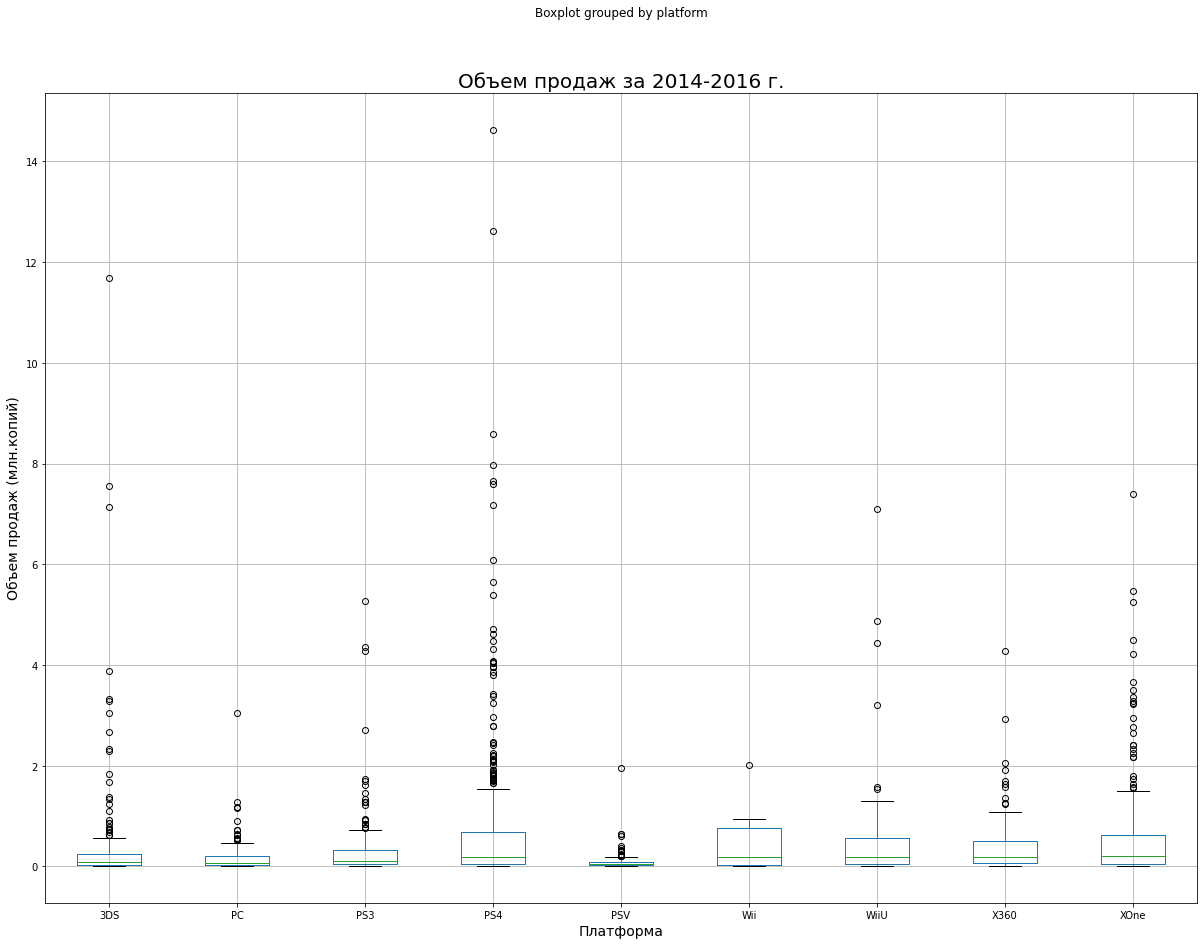

In [154]:
# Создадим список актуальных в 2016 году платформ:
actual_platform = ['3DS', 'PC', 'PS3', 'PS4', 'PSV', 'Wii', 'WiiU', 'X360', 'XOne']

# Построим диаграмму с применением фильтра:
df_actual.query('platform in @actual_platform').boxplot(
                column='total_sales', by='platform', figsize=(20, 15))
plt.title('Объем продаж за 2014-2016 г.', size=20)
plt.xlabel('Платформа', size=14)
plt.ylabel('Объем продаж (млн.копий)', size=14)
plt.show()

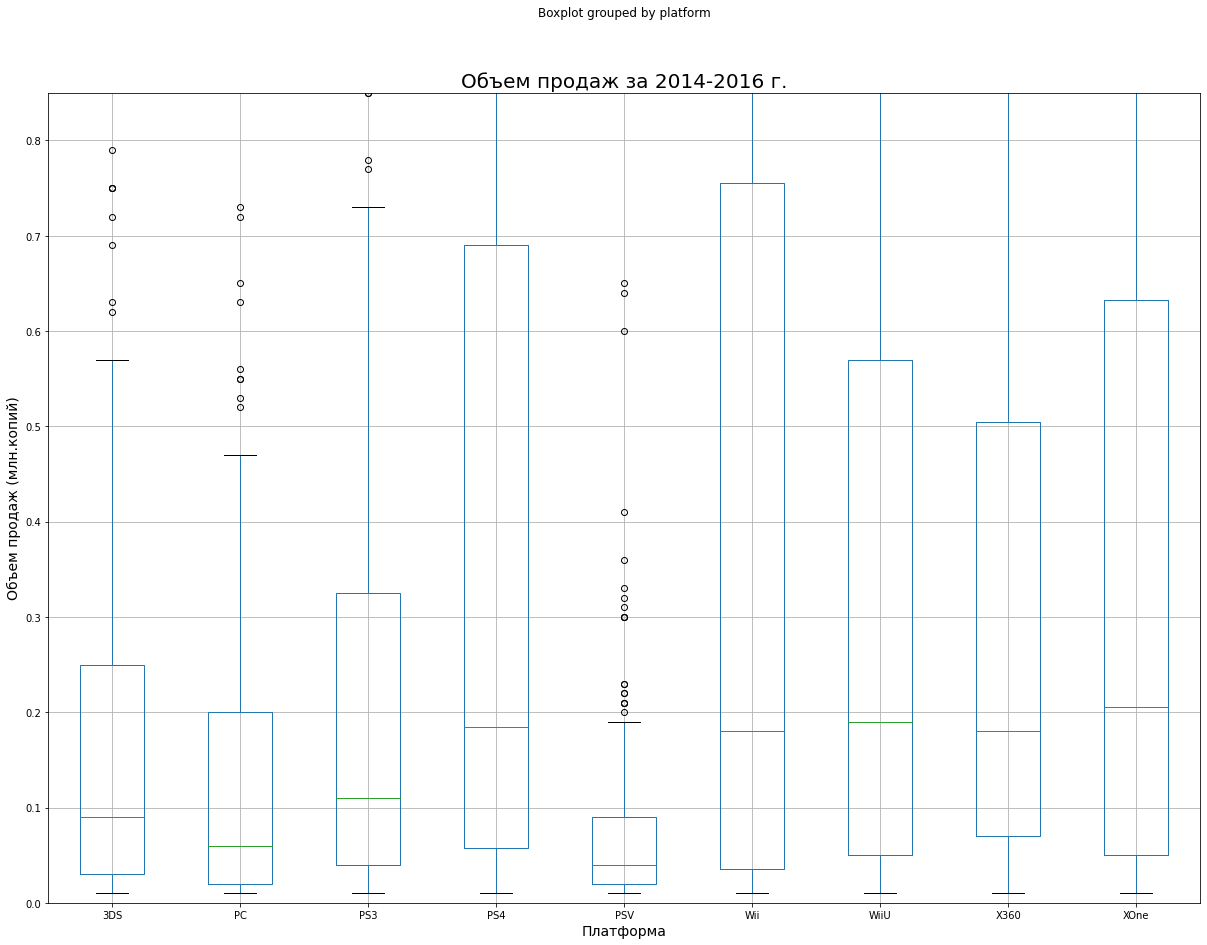

In [155]:
# То же самое, но для наглядности увеличим размеры "ящиков":
df_actual.query('platform in @actual_platform').boxplot(
                column='total_sales', by='platform', figsize=(20, 15)).set(ylim=(0,0.85))
plt.title('Объем продаж за 2014-2016 г.', size=20)
plt.xlabel('Платформа', size=14)
plt.ylabel('Объем продаж (млн.копий)', size=14)
plt.show()

Наибольшее медианное значение и самый длинный "верхний" хвост у PS3, PS4, Х360, XOne. <br>

Теперь посмотрим на общую динамику продаж по годам, это поможет увидеть, какая платформа на перспективу подходит нам больше всего.
<br>
Сгруппируем данные по годам и платформам на основании списка actual_platform (то есть тех, которые продаются на рынке в 2016 году).

In [156]:
df_actual_pivot = df_actual.query('platform in @actual_platform').pivot_table(
                       index='year_of_release', columns = 'platform', 
                       values = 'total_sales', aggfunc = 'sum')
df_actual_pivot

platform,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,
2014,43.76,13.28,47.76,100.00,11.90,3.75,22.03,34.74,54.07
2015,27.78,8.52,16.82,118.90,6.25,1.14,16.35,11.96,60.14
2016,15.14,5.25,3.60,69.25,4.25,0.18,4.60,1.52,26.15


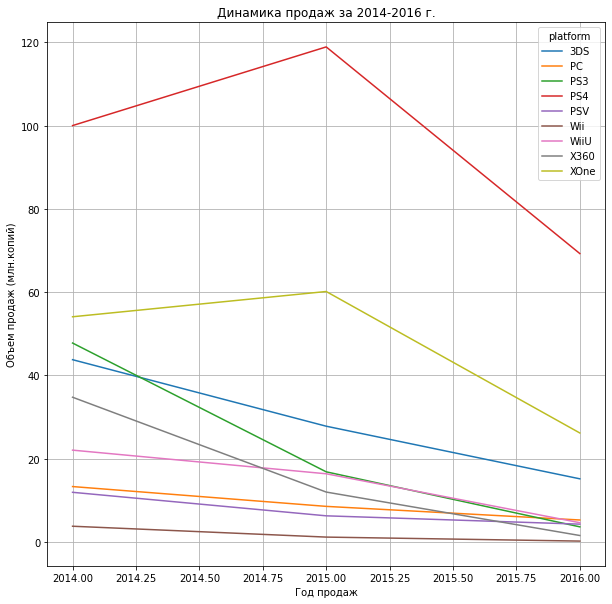

In [157]:
# Понятнее - на графике. 
# Посмотрим, в какой стадии находится каждая платформа.

df_actual_pivot.plot(grid=True, figsize=(10, 10), title = 'Динамика продаж за 2014-2016 г.').set(
                                     xlabel = 'Год продаж', ylabel = 'Объем продаж (млн.копий)');

In [158]:
df_actual_pivot.describe()

platform,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
count,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00
mean,28.89,9.02,22.73,96.05,7.47,1.69,14.33,16.07,46.79
std,14.34,4.04,22.66,25.06,3.97,1.85,8.89,16.99,18.13
min,15.14,5.25,3.60,69.25,4.25,0.18,4.60,1.52,26.15
25%,21.46,6.89,10.21,84.62,5.25,0.66,10.48,6.74,40.11
50%,27.78,8.52,16.82,100.00,6.25,1.14,16.35,11.96,54.07
75%,35.77,10.90,32.29,109.45,9.07,2.44,19.19,23.35,57.10
max,43.76,13.28,47.76,118.90,11.90,3.75,22.03,34.74,60.14


К концу 2016 года на рынке осталось 9 игроков, включая неизменный вариант PC (в отличие от игровых приставок, персональные компьютеры как класс никуда не пропадают, но постоянно модернизируются).

Что касается приставок, участники Топ-5 по общим продажам уже устарели.<br>
Лидеры продаж мирового рынка в конце 2016 года: PS4 (красная линия) - 69.25 млн., XOne (салатовая линия ниже) - 26.15 млн. и 3DS (синяя линия ниже XOne) - 15.4 млн.

Эти платформы относительно молоды (3-5 лет), но свой пик они уже прошли и не показывают потенциальных перспектив роста продаж.<br>
Их продажи пока выше остальных и какое-то время они способны удовлетворять спрос. <br>
Платформ с тенденцией роста к концу 2016 года нет, поэтому есть смысл сосредоточиться на PS4, XOne и 3DS.

**Вывод**

С 2010 года игровой рынок показывает стабильное снижение.<br>
Возможно, нет новых интересных технологий или игр, которые могли бы вернуть интерес пользователей.<br>

Мы понимаем, что в будущем неижбежно появится новая платформа. Пока этого не произошло, относительно свежие популярные платформы лучше всего справятся с поддержанием продаж: PS4, XOne и 3DS.<br>


**Влияние на продажи внутри одной популярной платформы отзывов пользователей и критиков.**

Рассчитаем корреляцию между объемом продаж и отзывами пользователей и критиков на актуальных в 2016 году платформах за актуальный период 2010-2016 г.

In [159]:
# Построим сводную таблицу значения коэффициента коррелияции на разных платформах
actual_platform_corr = platform_year.query('platform in @actual_platform')
actual_platform_corr['user_corr'] = 0
actual_platform_corr['critic_corr'] = 0

# Рассчитаем коэффициент корреляции
for name in actual_platform_corr['platform']:
    actual_platform_corr.loc[actual_platform_corr['platform'] == name,['user_corr']] = df_actual.query(
                 'platform == @name')['total_sales'].corr(df_actual.query('platform == @name')['user_score'])
    
    actual_platform_corr.loc[actual_platform_corr['platform'] == name,['critic_corr']] = df_actual.query(
                 'platform == @name')['total_sales'].corr(df_actual.query('platform == @name')['critic_score'])
    
actual_platform_corr

,platform,game_by_platform_count,game_by_platform_sales,user_corr,critic_corr
1,X360,1232,961.24,-0.14,0.53
2,PS3,1306,931.34,-0.17,0.45
3,Wii,1286,891.18,1.00,NaN
6,PS4,392,314.14,-0.04,0.40
9,3DS,512,257.81,0.22,0.31
10,PC,955,255.69,-0.07,0.17
16,XOne,247,159.32,-0.07,0.43
17,WiiU,147,82.19,0.41,0.37
18,PSV,429,53.81,-0.17,0.04


Корреляция между продажами и пользовательскими оценками в основном отрицательная или близкая к нулевой.<br>
Положительная просматривается только для продукции Nintendo: Wii - сильная, WiiU - слабая, 3DS - близкая к нулевой.<br>

Оценка критиков показывают средне-слабую положительную корреляцию (максимальный коэффициент у X360 - 0.53).<br>

Рассмотрим подробнее зависимость продаж от оценок пользователей на актуальных в 2016 году платформах. <br>
Для диаграмм возьмем данные за актуальный период (2014-2016):

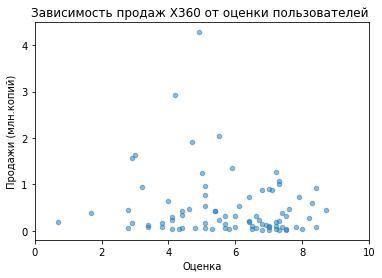

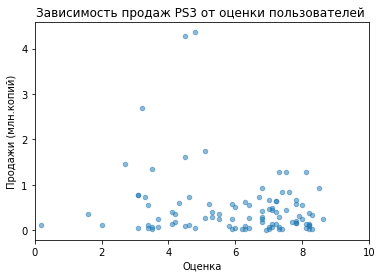

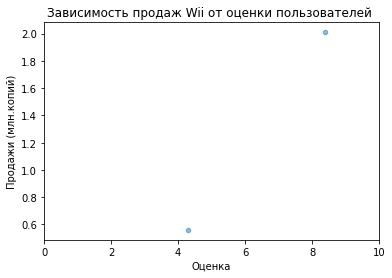

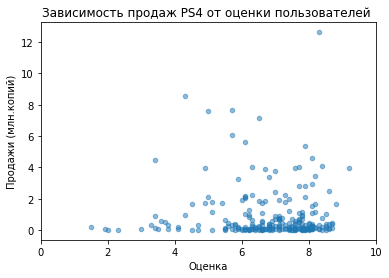

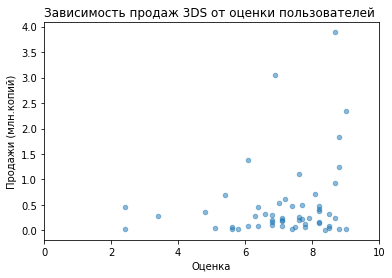

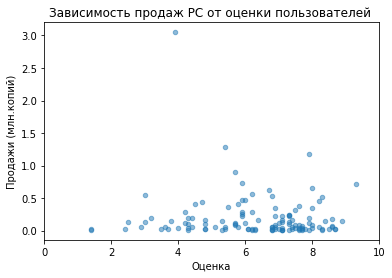

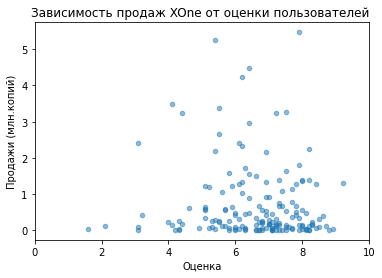

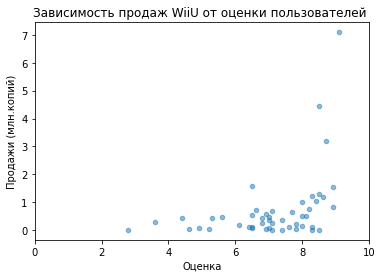

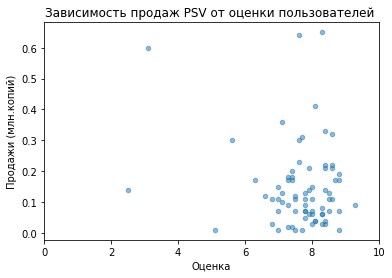

In [160]:
for name in actual_platform_corr['platform']:
    df_actual.query('platform == @name').plot(x='user_score', y='total_sales', kind='scatter', alpha=0.5,
                       title=f'Зависимость продаж {name} от оценки пользователей ').set(
                       xlabel='Оценка', ylabel='Продажи (млн.копий)');
    plt.xlim(0, 10)

На диаграммах рассеяния видна зависимость: чем больше оценка, тем выше плотность продаж, также в этих областях есть выбросы - продажи максимально большого количества копий.

Теперь оценки критиков:

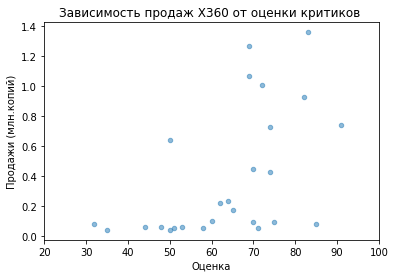

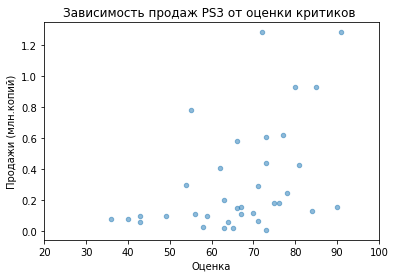

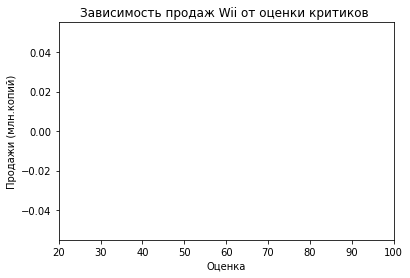

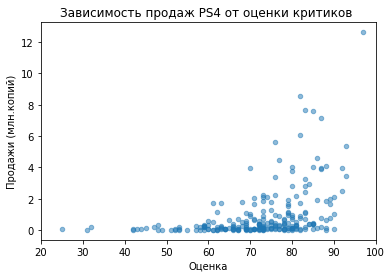

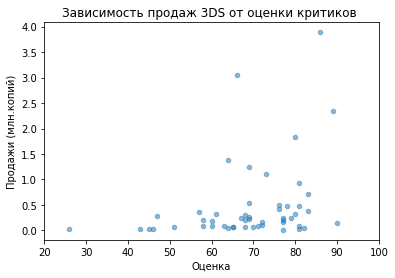

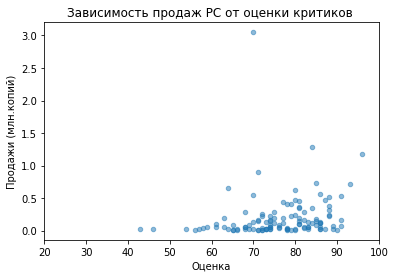

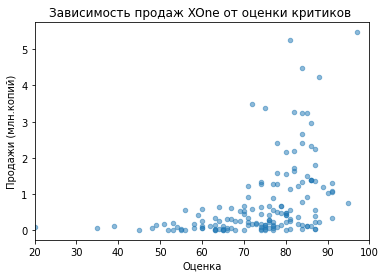

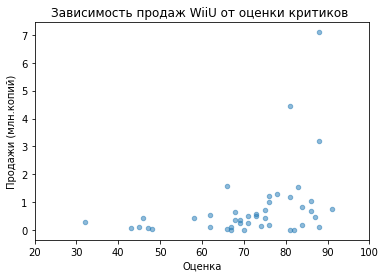

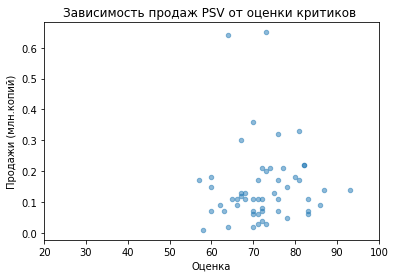

In [161]:
for name in actual_platform_corr['platform']:
    df_actual.query('platform == @name').plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.5,
                       title=f'Зависимость продаж {name} от оценки критиков ').set(
                       xlabel='Оценка', ylabel='Продажи (млн.копий)');
    plt.xlim(20, 100)

**Вывод**<br>
На графиках наблюдаем зависимости и от оценок пользователей, и от оценок критиков (зависимость ярче при рассмотрении оценок критиков).

**Общее распределение игр по жанрам.**<br>

Продажи по платформам и жанрам:

In [162]:
# Сначала по актуальным платформам
genre_pivot_total = df_actual.query('platform in @actual_platform').pivot_table(
                       index='genre', columns = 'platform', 
                       values = 'total_sales', aggfunc = 'sum').sum(axis = 1).sort_values(ascending=False)
genre_pivot_total

genre
Action         199.16
Shooter        170.94
Sports         109.39
Role-Playing   101.44
Misc            37.53
Fighting        28.22
Racing          27.52
Platform        18.09
Adventure       17.50
Simulation      13.13
Strategy         3.96
Puzzle           2.21
dtype: float32

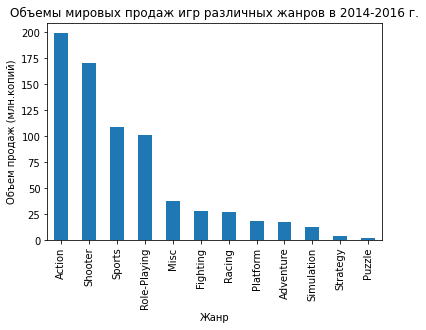

In [163]:
# То же самое на столбчатой диаграмме:
genre_pivot_total.plot.bar().set(
                       title = 'Объемы мировых продаж игр различных жанров в 2014-2016 г.',
                       xlabel = 'Жанр', ylabel = 'Объем продаж (млн.копий)');

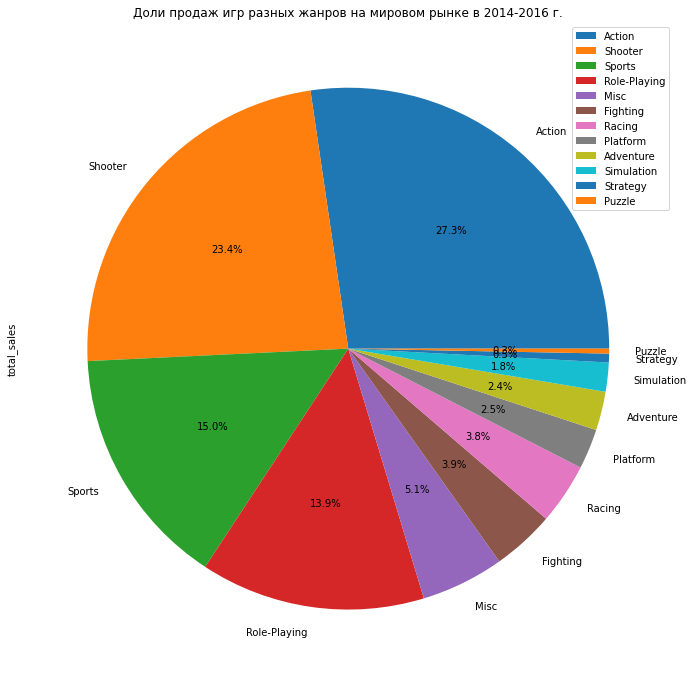

In [164]:
# На круговой диаграмме в %:

genre_pivot_total = genre_pivot_total.reset_index()
genre_pivot_total.columns = ['genre', 'total_sales']
genre_pivot_total.plot(kind = 'pie', y ='total_sales', autopct='%1.1f%%', figsize= (12,12),
                         title = 'Доли продаж игр разных жанров на мировом рынке в 2014-2016 г.',  
                         labels = genre_pivot_total['genre']);

Рассмотрим подробнее распределение продаж по жанрам и годам (объем продаж, медиану и среднее):

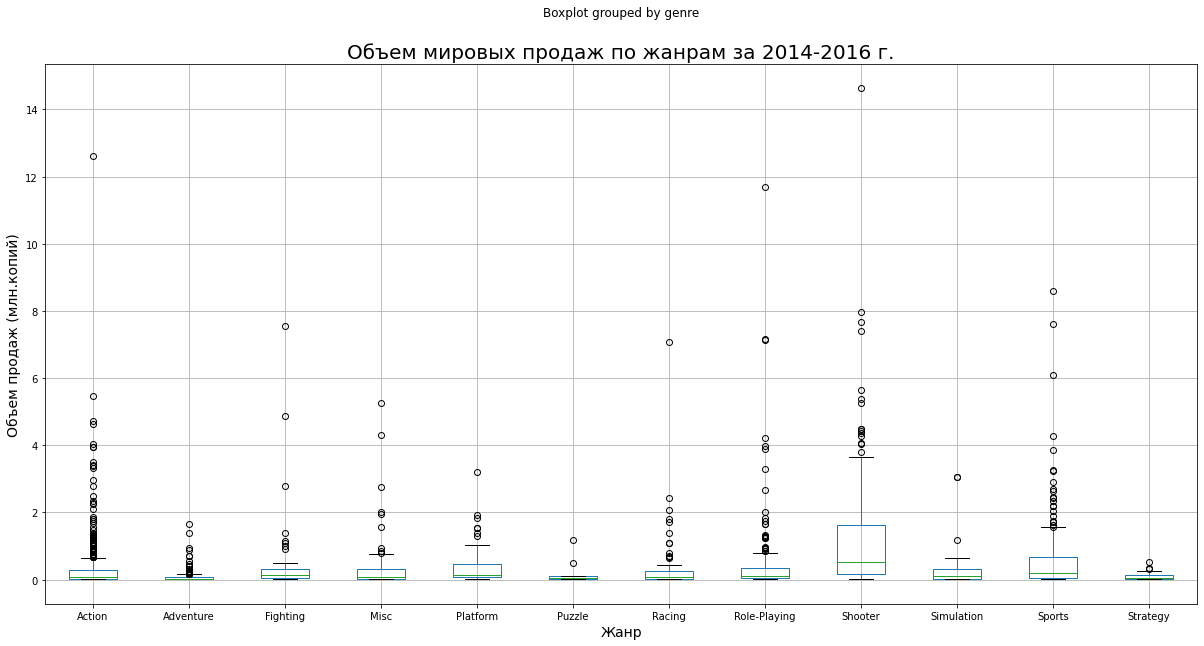

In [165]:
# Продажи по жанрам в целом

df_actual.query('platform in @actual_platform').boxplot(
                column='total_sales', by='genre', figsize=(20, 10))
plt.title('Объем мировых продаж по жанрам за 2014-2016 г.', size=20)
plt.xlabel('Жанр', size=14)
plt.ylabel('Объем продаж (млн.копий)', size=14)
plt.show()

In [168]:
# Среднее продаж по жанрам
df_actual.query('platform in @actual_platform').pivot_table(
                       index='year_of_release', columns = 'genre', 
                       values = 'total_sales', aggfunc = 'mean')

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
year_of_release,,,,,,,,,,,,
2014,0.53,0.08,0.69,0.58,0.88,0.21,0.62,0.51,1.39,0.51,0.85,0.12
2015,0.29,0.15,0.38,0.30,0.47,0.12,0.45,0.48,1.99,0.38,0.69,0.12
2016,0.17,0.07,0.28,0.08,0.22,0.01,0.12,0.34,0.81,0.10,0.49,0.09


In [166]:
# Медиана продаж по жанрам
df_actual.query('platform in @actual_platform').pivot_table(
                       index='year_of_release', columns = 'genre', 
                       values = 'total_sales', aggfunc = 'median')

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
year_of_release,,,,,,,,,,,,
2014,0.21,0.05,0.13,0.17,0.83,0.05,0.17,0.11,0.66,0.12,0.46,0.06
2015,0.08,0.03,0.10,0.19,0.10,0.04,0.15,0.11,0.93,0.20,0.12,0.05
2016,0.05,0.02,0.08,0.04,0.10,0.01,0.05,0.12,0.24,0.02,0.12,0.06


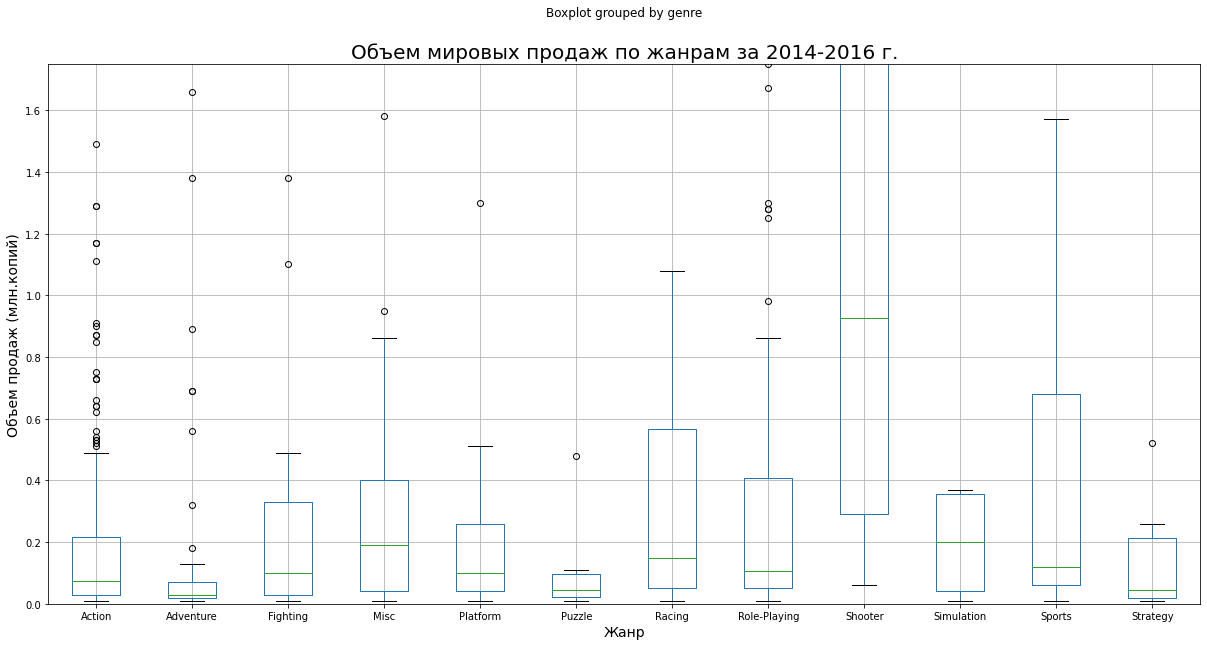

In [169]:
# Увеличим область медианы:

df_actual.query('platform in @actual_platform and 2014 < year_of_release < 2016' ).boxplot(
                column='total_sales', by='genre', figsize=(20, 10)).set(ylim = (0, 1.75))
plt.title('Объем мировых продаж по жанрам за 2014-2016 г.', size=20)
plt.xlabel('Жанр', size=14)
plt.ylabel('Объем продаж (млн.копий)', size=14)
plt.show()

За 3 актуальных года в продажах лидируют жанры Action, Shooter, Sports, Role-Playing и Misc.<br>

Если посмотреть на медианные значения, то абсолютные лидеры (по всем значениям, попавшим в межквартильный интервал, медиане и среднему объема продаж) - жанры Shooter, Sport, Role-Playing. <br>

Action менее стабилен в продажах и имеет наибольшее количество выбросов, значит популярность обеспечивает небольшое количество очень удачных игр, "редко, но метко".

**Вывод**<br>
Итак, по продажам за 3 года лидируют жанры:
- Action, 
- Shooter, 
- Sports, 
- Role-Playing,
- Misc.
<br>

Совсем не пользуются популярностью:
- Adventure, 
- Strategy,
- Puzzle.
<br>

Наиболее перспективные для составления прогноза жанры это Shooter, Sports и Role-Playing, они показывают более стабильные, высокие и предсказуемые значения продаж.

**Суммируем вывод по исследовательскому анализу**<br>
Компании, выпускающие самые популярные игровые платформы: Sony, Microsoft и Nintendo.<br>
Топ-5 платформ: PS2, PS3, X360, Wii, DS.<br>
Средний срок жизни платформы составляет 11 лет.<br>

Также объединяет все платформы динамика их популярности: резкий всплеск продаж через год (или сразу же в первый год), затем 5-летний период высокой популярности, а после - резкий спад, длящийся до 5 лет.<br>
Средний срок жизни платформы исходя из всего набора данных по всем 30 платформам составляет 7 лет, однако актуальным периодом мы будем считать 2014-2016 годы (игровая индустрия динамично меняется, и срок более 3 лет уже может быть не показателен).<br>

С 2014 года игровой рынок показывает стабильное снижение (а начался он и вовсе в 2010).<br>
Возможно, нет новых интересных технологий или игр, которые могли бы вернуть интерес пользователей.<br>
Мы понимаем, что в будущем неижбежно появится новая платформа. Пока этого не произошло, относительно свежие популярные платформы лучше всего справятся с поддержанием продаж: PS4, XOne и 3DS.<br>

Наблюдаются зависимости продаж и оценок пользователей и критиков (зависимость ярче при рассмотрении оценок критиков).<br>
<br>
По продажам за 3 года лидируют жанры:
- Action,
- Shooter,
- Sports,
- Role-Playing,
- Misc.
<br>

Совсем не пользуются популярностью:
- Adventure,
- Strategy,
- Puzzle.
<br>

Наиболее перспективные для составления прогноза жанры это Shooter, Sports и Role-Playing, они показывают более стабильные, высокие и предсказуемые значения продаж.

### Портрет пользователя каждого региона
**Самые популярные платформы (топ-5)**<br>
Создадим словарь с данными по продажам Топ-5 платформ в 3 регионах.

In [170]:
top_5_platf_dict = {}
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    top_5_platf_dict[region] = df_actual.groupby('platform')[region].sum().sort_values(ascending=False).head(5)

top_5_platf_dict

{'na_sales': platform
 PS4    98.61
 XOne   81.27
 X360   28.30
 3DS    22.64
 PS3    22.05
 Name: na_sales, dtype: float32,
 'eu_sales': platform
 PS4    130.04
 XOne    46.25
 PS3     25.54
 PC      17.97
 3DS     16.12
 Name: eu_sales, dtype: float32,
 'jp_sales': platform
 3DS    44.24
 PS4    15.02
 PSV    14.54
 PS3    11.22
 WiiU    7.31
 Name: jp_sales, dtype: float32}

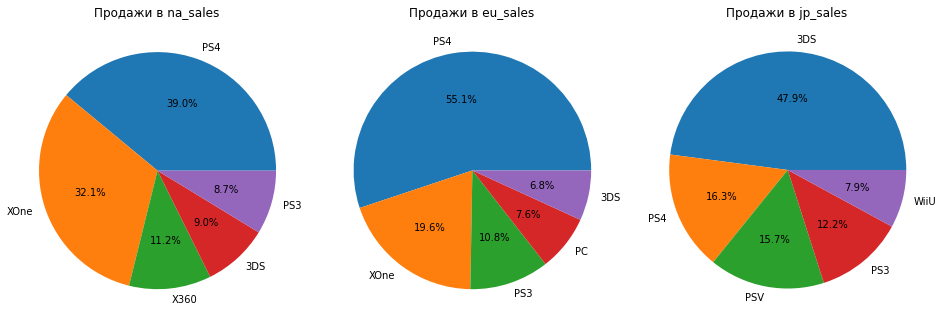

In [171]:
# Теперь отразим это всё на графиках

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
fig.autofmt_xdate();

i = 0
x = [ax1, ax2, ax3]
region = ['na_sales', 'eu_sales', 'jp_sales']

for i in [0,1,2]:
    labels = top_5_platf_dict[region[i]].index
    sizes = top_5_platf_dict[region[i]].values
    ax = x[i]
    ax.set_title(f'Продажи в {region[i]}')
    ax.pie(sizes, labels=labels, autopct='%1.1f%%') 
    ax.axis('equal')  

plt.show()

**Вывод**<br> 

- Америка - PS4 на первом месте, а PS3 на пятом, но суммарно они занимают долю больше, чем конкуренты XOne и X360 (второе и третье место). Продукция Microsoft представлена сильнее, чем в других регионах (объяснимо - отечественный производитель, качество которого не уступает японским конкурентам).
- Европа - PS4 формирует рынок, также остается небольшая доля PS3. XOne занимает скромные, но заметные 19.6%.
- Япония - Отечественные бренды полностью заняли рынок, причём карманные 3DS и PSV занимают больше рынка, чем полноразмерные платформы.<br>

В Америке и Европе пользуются в основном одними и теми же платформами - PS3-4, XOne, 3DS. <br>

Sony PS4 популярна во всех регионах.<br>

Японские бренды представлены (и лидируют) во всех исследуемых регионах, но американский Xbox от Microsoft есть только в Штатах, и немного в Европе.

**Самые популярные жанры в регионах (топ-5)**<br>
Создадим словарь с данными по продажам Топ-5 жанров в 3 регионах.

In [173]:
top_5_genre_dict = {}
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    top_5_genre_dict[region] = df_actual.groupby('genre')[region].sum().sort_values(ascending=False).head(5)
top_5_genre_dict

{'na_sales': genre
 Shooter        79.02
 Action         72.53
 Sports         46.13
 Role-Playing   33.47
 Misc           15.05
 Name: na_sales, dtype: float32,
 'eu_sales': genre
 Action         74.68
 Shooter        65.52
 Sports         45.73
 Role-Playing   28.17
 Racing         14.13
 Name: eu_sales, dtype: float32,
 'jp_sales': genre
 Role-Playing   31.16
 Action         29.58
 Fighting        6.37
 Misc            5.61
 Shooter         4.87
 Name: jp_sales, dtype: float32}

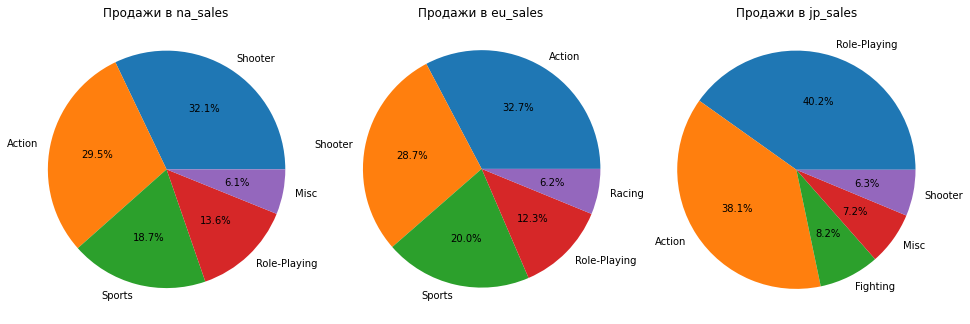

In [174]:
# Теперь отразим это всё на графиках

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
fig.autofmt_xdate();

i = 0
x = [ax1, ax2, ax3]
region = ['na_sales', 'eu_sales', 'jp_sales']

for i in [0,1,2]:
    labels = top_5_genre_dict[region[i]].index
    sizes = top_5_genre_dict[region[i]].values
    ax = x[i]
    ax.set_title(f'Продажи в {region[i]}')
    ax.pie(sizes, labels=labels, autopct='%1.1f%%') 
    ax.axis('equal')  

plt.show()

**Вывод:**<br> 
Лидеры жанров в Европе и Америке похожи, а Япония снова отличилась: 
- Америка - Shooter на первом месте, затем Action, Sports и Role-Playing. Замыкает рейтинг категория Misc - всё, что не попало в первые 4 группы.
- Европа - здесть Action на первом месте, затем Shooter. Далее сопоставимые с Америкой доли Sports и Role-Playing. На 5 месте категория Racing.
- Япония - лидирует жанр Role-Playing (видимо, под влиянием культуры аниме и супергероев), затем Action.<br>
Только в Японии замечен жанр Fighting, возможно, сказывается историческое влияние японской культуры борьбы, самураев и супергероев.

**Влияние рейтинга ESRB на продажи в отдельных регионах**<br>
ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».
<br>

Сгруппируем данные продаж в разных странах по рейтингу ESRB:

In [176]:
esrb_sales = df_actual.groupby('rating')['na_sales', 'eu_sales', 'jp_sales'].sum().sort_values(by='na_sales', \
                                                                                       ascending=False)
esrb_sales

,na_sales,eu_sales,jp_sales
rating,,,
M,96.42,93.44,8.01
no rating,64.72,58.95,56.90
E,50.74,58.06,8.94
T,38.95,34.07,14.78
E10+,33.23,26.16,4.46


- «E» («Everyone») — «Для всех»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «EC»(«K-A» - в ранних версиях с 1994-1997 годы) («Early childhood») — «Для детей младшего возраста»
- «AO» («Adults Only 18+») — «Только для взрослых»
- «RP» («Rating Pending») — «Рейтинг ожидается»

Перенесем на график:

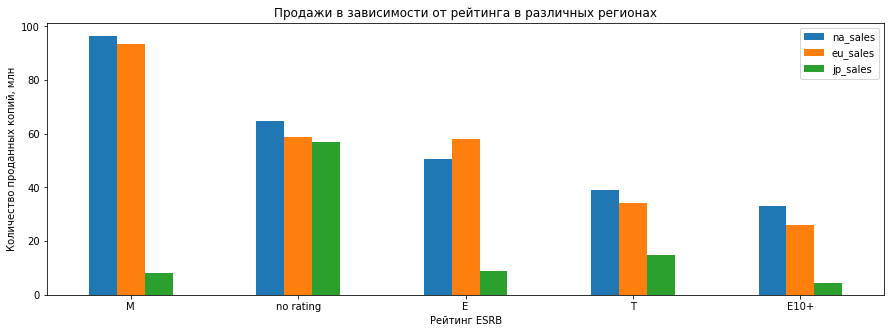

In [177]:
esrb_sales.plot(kind='bar', figsize=(15, 5))
plt.xticks(rotation = 0)
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Количество проданных копий, млн')
plt.title('Продажи в зависимости от рейтинга в различных регионах')
plt.show()

**Вывод:**<br>
Не считая категории без указания рейтинга, есть 4 основных типа: «E»,«T»,«M» и «E10+».<br>
Количество игр без рейтинга достаточно велико для всех исследуемых стран

- Америка: на первом месте «М»(для взрослых), «no rating» на втором, далее «Е»(для всех), «Т»(подросткам) и «E10+».
- Европа: то же, что и в Америке, только продажи с рейтингом «Е»(для всех) чуть больше, чем «no rating».
- Япония: снова совсем другая картина. Здесь больше всего продаж «no rating», остальные категории представлены гораздо меньше и примерно равны между собой.

**Вывод по исследованию портрета пользователя**<br>
Мировой рынок компьютерных игр можно разделить на две части: Япония отдельно, и остальные регионы (Северная Америка, Европа и другие).<br>

- ***Производители приставок***<br>
Япония предпочитает продукцию Sony (различные виды PS) и Nintendo (DS, Wii), однако в Америке (и, в меньшей степени, в Европе), конкуренцию составляет продукция Microsoft (X360 и XOne).<br>
За пределами Японии Sony и Nintendo тоже популярны, лидируют во всех исследуемых регионах.
<br>

- ***Жанры***<br>
В Европе и Америке первые 2 места делят Action и Shooter. На третьем месте Sports (занимает ~20%).<br>
Только в Японии лидирует Role-Playing (Action второй), а Shooter на скромном пятом месте.
<br>

- ***Возрастной рейтинг***<br>
Не считая категории без указания рейтинга, есть 4 основных типа: «E»,«T»,«M» и «E10+».
Количество игр без рейтинга достаточно велико для всех исследуемых стран.<br>
 *Америка*: на первом месте «М»(для взрослых), «no rating» на втором, далее «Е»(для всех), «Т»(подросткам) и «E10+».<br>
 *Европа*: то же, что и в Америке, только продажи с рейтингом «Е»(для всех) чуть больше, чем «no rating».<br>
 *Япония*: снова совсем другая картина. Здесь больше всего продаж «no rating», остальные категории представлены гораздо меньше и примерно равны между собой.

### Проверка гипотез
Для проверки гипотез сравним данные за актуальный период, которые сохранены в переменной df_actual.<br>
Для анализа будем использовать t-критерий Стьюдента, поскольку сравниваемые выборки независимы между собой.<br>
Поскольку оценки имеют фиксированные шкалы, удалять выбросы не будем, но очистим данные от пропусков.

**Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**<br>
Сформулируем гипотезы:

- Н0: средние пользовательские рейтинги платформ Xbox One и PC равны
- Н1: средние пользовательские рейтинги платформ Xbox One и PC не равны

In [71]:
#выборки пользовательских рейтингов по платформам, очищенные от пропусков:
XOne = df_actual.query('platform == "XOne" and user_score.notna()')['user_score']
PC = df_actual.query('platform == "PC" and user_score.notna()')['user_score']

In [72]:
alpha = .05
results = st.ttest_ind(PC,XOne)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.9810063009185758
Не получилось отвергнуть нулевую гипотезу


**Вывод**<br>
Гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковы, не опровергнута.

**Средние пользовательские рейтинги жанров Action и Sports разные**<br>
Сформулируем гипотезы:
- Н0: средние пользовательские рейтинги жанров Action и Sport равны
- Н1: средние пользовательские рейтинги жанров Action и Sport не равны

In [73]:
#выборки пользовательских рейтингов по платформам, очищенные от пропусков:
Action = df_actual.query('genre == "Action" and user_score.notna()')['user_score']
Sports = df_actual.query('genre == "Sports" and user_score.notna()')['user_score']

In [74]:
alpha = .05
results = st.ttest_ind(Action, Sports)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 7.839221389457081e-19
Отвергаем нулевую гипотезу


**Вывод**<br>
Разница не случайна, есть значимые различия между выборками, а значит средние пользовательские рейтинги отличаются.

**Вывод по проверке гипотез**<br>
У нас нет оснований опровергать гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC равны<br>
У нас нет оснований утверждать, что  средние пользовательские рейтинги жанров Action и Sport равны.

### **Общий вывод по исследованию продаж компьютерных игр**<br>

Перед нами стояла цель: выявить закономерности, определяющие успешность игры, чтобы в дальнейшем сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.<br>

Представленные для анализа данные содержат информацию исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы за 1980-2016 годы.<br>

**В результате предобработки данных:**<br>
- Наименования столбцов переписаны в нижнем регистре,
- Удалены строки с пропусками данных в столбцах name и rating (2 строки), year_of_release (269 строк),
- Значения 'tbd' в столбце user_score изменено на значение пропуска (nan),
- Пропуски значений столбца rating заменены на значение 'no rating',
- Пропуски значений столбца user_score и critic_score оставлены без изменений в связи с невозможностью корректной замены,
- Создан столбец total_sales, суммирующий продажи во всех регионах.

**Результат анализа:**<br>
Компании, выпускающие самые популярные игровые платформы: Sony, Microsoft и Nintendo.<br>
Топ-5 платформ: PS2, PS3, X360, Wii, DS.<br>
Средний срок жизни платформы составляет 11 лет.<br>

Также объединяет все платформы динамика их популярности: резкий всплеск продаж через год (или сразу же в первый год), затем 5-летний период высокой популярности, а после - резкий спад, длящийся до 5 лет.<br>
Средний срок жизни платформы исходя из всего набора данных по всем 30 платформам составляет 7 лет, поэтому актуальным периодом мы считаем 2010-2016 годы.<br>

С 2010 года игровой рынок показывает стабильное снижение.<br>
Возможно, нет новых интересных технологий или игр, которые могли бы вернуть интерес пользователей.<br>
Мы понимаем, что в будущем неижбежно появится новая платформа. Пока этого не произошло, относительно свежие популярные платформы лучше всего справятся с поддержанием продаж: PS4, XOne и 3DS.<br>

Объёмы продаж зависят и от оценок пользователей, и от оценок критиков.<br>
Зависимость ярче при рассмотрении оценок критиков: от их мнения буквально зависят продажи игры.<br>
<br>
По продажам за 7 лет лидируют жанры: Action, Shooter, Sports, Role-Playing, Misc.<br>
Совсем не пользуются популярностью: Adventure, Strategy, Puzzle.<br>

Наиболее перспективные для составления прогноза жанры это Shooter, Sports и Role-Playing, они показывают более стабильные, высокие и предсказуемые значения продаж.

**Исследование портрета пользователя**<br>
Мировой рынок компьютерных игр можно разделить на две части: Япония отдельно, и остальные регионы (Северная Америка, Европа и другие).<br>
- ***Производители приставок***<br>
Япония предпочитает продукцию Sony (различные виды PS) и Nintendo (DS, Wii), однако в Америке (и, в меньшей степени, в Европе), конкуренцию составляет продукция Microsoft (X360 и XOne).<br>
За пределами Японии Sony и Nintendo тоже популярны, лидируют во всех исследуемых регионах.
<br>

- ***Жанры***<br>
В Европе и Америке первые 2 места делят Action и Shooter. На третьем месте Sports (занимает ~20%).<br>
Только в Японии лидирует Role-Playing (Action второй), а Shooter на скромном пятом месте.
<br>

- ***Возрастной рейтинг***<br>
Не считая категории без указания рейтинга, есть 4 основных типа: «E»,«T»,«M» и «E10+».
Количество игр без рейтинга достаточно велико для всех исследуемых стран.<br>
 *Америка*: на первом месте «М»(для взрослых), «no rating» на втором, далее «Е»(для всех), «Т»(подросткам) и «E10+».<br>
 *Европа*: то же, что и в Америке, только продажи с рейтингом «Е»(для всех) чуть больше, чем «no rating».<br>
 *Япония*: снова совсем другая картина. Здесь больше всего продаж «no rating», остальные категории представлены гораздо меньше и примерно равны между собой.

**Также в результате проверки гипотез мы выяснили:**<br>
У нас нет оснований опровергать гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC равны<br>
У нас нет оснований утверждать, что  средние пользовательские рейтинги жанров Action и Sport равны.